In [ ]:
cd ../

In [2]:
import pickle
import numpy as np
import argparse

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist

from tensorflow.python.keras.layers import Dense, Input, Flatten, Add, Multiply, Lambda
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

from utils.explanations import calculate_robust_astute_sampled

np.random.seed(0)

/home/zulqarnain/anaconda3/envs/old_tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zulqarnain/anaconda3/envs/old_tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zulqarnain/anaconda3/envs/old_tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zulqarnain/anaconda3/envs/ol

In [3]:
datatype = 'telescope'
run_times = 5
prop_points = 0.05
calculate = True
epsilon_range = np.arange(0.01, 1.1, 0.05)

In [4]:
data_dict = pd.read_csv('data/magic04.data').values
data = data_dict[:, :-1]
labels = data_dict[:, -1]
labels[labels == 'h'] = 0
labels[labels == 'g'] = 1
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.05, stratify=labels, random_state=42)
x_train = StandardScaler().fit_transform(x_train)
x_val = StandardScaler().fit_transform(x_val)
input_shape = x_train.shape[-1]

In [5]:
median_rad = np.median(pdist(x_train))

In [6]:
save_astuteness_file = 'plots/rise_' + datatype + '_astuteness_classifiers.pk'
classifiers = ['2layer', '4layer', 'linear', 'svm']

Completing Run 1 of 5
Instructions for updating:
Colocations handled automatically by placer.


2022-05-18 12:07:01.016385: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-18 12:07:01.038031: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2022-05-18 12:07:01.038344: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x557861900820 executing computations on platform Host. Devices:
2022-05-18 12:07:01.038358: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
  0%|                                              | 0/22 [00:00<?, ?it/s]

Completing Run 2 of 5


  0%|                                              | 0/22 [00:00<?, ?it/s]

Completing Run 3 of 5


  0%|                                              | 0/22 [00:00<?, ?it/s]

Completing Run 4 of 5


  0%|                                              | 0/22 [00:00<?, ?it/s]

Completing Run 5 of 5


100%|████████████████████████████████████| 22/22 [41:30<00:00, 113.20s/it]


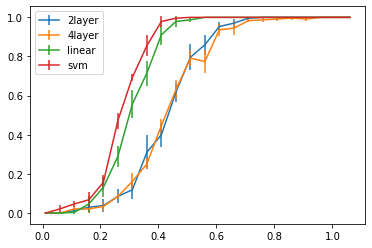

In [7]:
if calculate:
    total_astuteness = np.zeros(shape=(run_times, len(classifiers), len(epsilon_range)))
    for i in range(run_times):
        print('Completing Run ' + str(i + 1) + ' of ' + str(run_times))
        for j in range(len(classifiers)):
            if classifiers[j] == '2layer':
                activation = 'relu'

                model_input = Input(shape=(input_shape,), dtype='float32')

                net = Dense(32, activation=activation, name='dense1',
                            kernel_regularizer=regularizers.l2(1e-3))(model_input)

                preds = Dense(1, activation='sigmoid', name='dense3',
                              kernel_regularizer=regularizers.l2(1e-3))(net)
                bbox_model = Model(model_input, preds)
                bbox_model.load_weights('models/' + datatype + '_blackbox.hdf5',
                                        by_name=True)
                pred_model = Model(model_input, preds)

            elif classifiers[j] == '4layer':
                activation = 'relu' if datatype in ['orange_skin', 'XOR'] else 'selu'

                model_input = Input(shape=(input_shape,), dtype='float32')

                net = Dense(32, activation=activation, name='dense1',
                            kernel_regularizer=regularizers.l2(1e-3))(model_input)
                net = Dense(32, activation=activation, name='dense2',
                            kernel_regularizer=regularizers.l2(1e-3))(net)
                net = Dense(32, activation=activation, name='dense3',
                            kernel_regularizer=regularizers.l2(1e-3))(net)
                net = Dense(32, activation=activation, name='dense4',
                            kernel_regularizer=regularizers.l2(1e-3))(net)
                preds = Dense(1, activation='sigmoid', name='dense5',
                              kernel_regularizer=regularizers.l2(1e-3))(net)
                bbox_model = Model(model_input, preds)
                bbox_model.load_weights('models/' + datatype + '_blackbox_extra.hdf5',
                                        by_name=True)
                pred_model = Model(model_input, preds)


            elif classifiers[j] == 'linear':
                activation = None

                model_input = Input(shape=(input_shape,), dtype='float32')

                net = Dense(32, activation=activation, name='dense1',
                            kernel_regularizer=regularizers.l2(1e-3))(model_input)

                preds = Dense(1, activation='sigmoid', name='dense3',
                              kernel_regularizer=regularizers.l2(1e-3))(net)
                bbox_model = Model(model_input, preds)
                bbox_model.load_weights('models/' + datatype + '_blackbox_linear.hdf5',
                                        by_name=True)
                pred_model = Model(model_input, preds)
            elif classifiers[j] == 'svm':
                pred_model = pickle.load(open('models/' + datatype + '_svm.pk', 'rb'))
            fname = 'explained_weights/rise/' + 'rise_' + datatype + '_' + classifiers[j] + '_' + str(
                i) + '.gz'
            explanations = np.loadtxt(fname, delimiter=',')
            if classifiers[j] == 'svm':
                for k in tqdm(range(len(epsilon_range))):
                    _, total_astuteness[i, j, k], _ = calculate_robust_astute_sampled(data=x_val,
                                                                                      explainer=pred_model,
                                                                                      explainer_type='rise',
                                                                                      explanation_type='attribution',
                                                                                      ball_r=median_rad,
                                                                                      epsilon=epsilon_range[k],
                                                                                      num_points=int(
                                                                                          prop_points * len(
                                                                                              x_val)),
                                                                                      NN=False,
                                                                                      data_explanation=explanations)
            else:
                for k in tqdm(range(len(epsilon_range))):
                    _, total_astuteness[i, j, k], _ = calculate_robust_astute_sampled(data=x_val,
                                                                                      explainer=pred_model,
                                                                                      explainer_type='rise',
                                                                                      explanation_type='attribution',
                                                                                      ball_r=median_rad,
                                                                                      epsilon=epsilon_range[k],
                                                                                      num_points=int(
                                                                                          prop_points * len(
                                                                                              x_val)),
                                                                                      NN=True,
                                                                                      data_explanation=explanations)
    pickle.dump(total_astuteness, open(save_astuteness_file, 'wb'))
else:
    total_astuteness = pickle.load(open(save_astuteness_file, 'rb'))
astuteness_mean = total_astuteness.mean(axis=0)
astuteness_std = total_astuteness.std(axis=0)
image_name = 'plots/rise_' + datatype + '_astuteness_classifiers.PNG'
fig, ax = plt.subplots()
for i in range(len(classifiers)):
    ax.errorbar(x=epsilon_range, y=astuteness_mean[i, :], yerr=astuteness_std[i, :],
                label=classifiers[i])
plt.legend()
plt.savefig(image_name)